In [46]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns

from utils.load_data import load_data
from utils.preprocessing import preprocess_data
from models.BaseModel import BaseModel
from models.KFModel import KFModel

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
SEED = 0
EPS = 1e-6
TRAIN_PROPORTION = 0.9

In [48]:
data = load_data()

X, y, countries, y_mean, y_std = preprocess_data(data=data, epsilon=EPS)

X

,date,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,...,Artificial_intelligence_average,International_Financial_Reporting_Standards_average,Employment_average,country_Canada,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States
616,-1.771126,-1.060998,2.871241,-1.696290,1.582391,-0.732737,-0.290201,-0.604001,-0.078562,0.186376,...,-0.395035,-1.710910,1.689417,2.404072,-0.415202,-0.365754,-0.412192,-0.415202,-0.415202,-0.415202
6646,-1.771126,-0.036149,3.231815,0.589877,1.653900,-0.682008,1.399695,0.082269,1.703260,0.763066,...,-0.453614,-0.598496,1.689417,-0.415202,-0.415202,-0.365754,-0.412192,-0.415202,-0.415202,2.404072
6173,-1.771126,-1.009755,2.751049,-1.696290,1.718909,-1.037115,-0.773029,1.073548,2.594171,2.276877,...,-0.277877,0.745671,2.102636,-0.415202,-0.415202,-0.365754,-0.412192,-0.415202,2.404072,-0.415202
3645,-1.771126,-0.446089,2.210188,-1.696290,0.516251,0.636960,0.313333,-0.604001,0.875985,3.790688,...,-0.336456,-1.710910,1.839678,-0.415202,-0.415202,-0.365754,2.421629,-0.415202,-0.415202,-0.415202
5892,-1.771126,2.782184,-2.417180,-1.696290,1.426370,-1.290762,1.327271,-0.604001,2.530535,-3.273764,...,-0.043561,-1.710910,0.900544,-0.415202,-0.415202,-0.365754,-0.412192,2.404072,-0.415202,-0.415202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,1.715275,2.116032,-0.361907,1.555148,1.114329,2.006658,3.149944,-0.222740,1.130532,1.700187,...,5.111383,0.421217,0.862979,2.404072,-0.415202,-0.365754,-0.412192,-0.415202,-0.415202,-0.415202
6413,1.715275,-0.138634,1.248657,0.132644,0.776285,1.093526,2.727470,-0.451496,1.575987,3.574430,...,4.759909,-0.274042,1.802113,-0.415202,-0.415202,-0.365754,-0.412192,-0.415202,2.404072,-0.415202
2588,1.715275,0.783729,-0.313831,1.605952,0.256216,2.311035,2.425703,-0.604001,1.639624,0.979325,...,4.818488,-0.459444,-0.865028,-0.415202,2.404072,-0.365754,-0.412192,-0.415202,-0.415202,-0.415202
6132,1.715275,1.808578,-1.395553,1.656756,0.841293,2.361764,3.270651,-0.604001,2.530535,1.988532,...,5.111383,-0.181340,1.464025,-0.415202,-0.415202,-0.365754,-0.412192,2.404072,-0.415202,-0.415202


In [49]:
y

616    -1.110615
6646   -0.539413
6173   -1.228650
3645   -1.837559
5892   -0.636078
          ...   
856     1.002158
6413    0.930596
2588    1.739899
6132    3.454888
6886    2.755538
Name: GDP, Length: 550, dtype: float64

In [50]:
number_train = int(len(X) * TRAIN_PROPORTION)

X_train, X_valid  = X.values[:number_train, :], X.values[number_train:, :]
y_train, y_valid = y.values[:number_train], y.values[number_train:]
country_train = countries.values[:number_train]
country_valid = countries.values[number_train:]


In [51]:
model = BaseModel(seed=SEED, n_models=5)

# Fit and predict on training and validation data
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

kf_model = KFModel(seed=SEED)

# Fit and predict on training and validation data with Kalman Filter
y_pred_train_kf = kf_model.fit(X_train, y_train, country_train)
y_pred_valid_kf = kf_model.predict(X_valid, country_valid)




Base model :


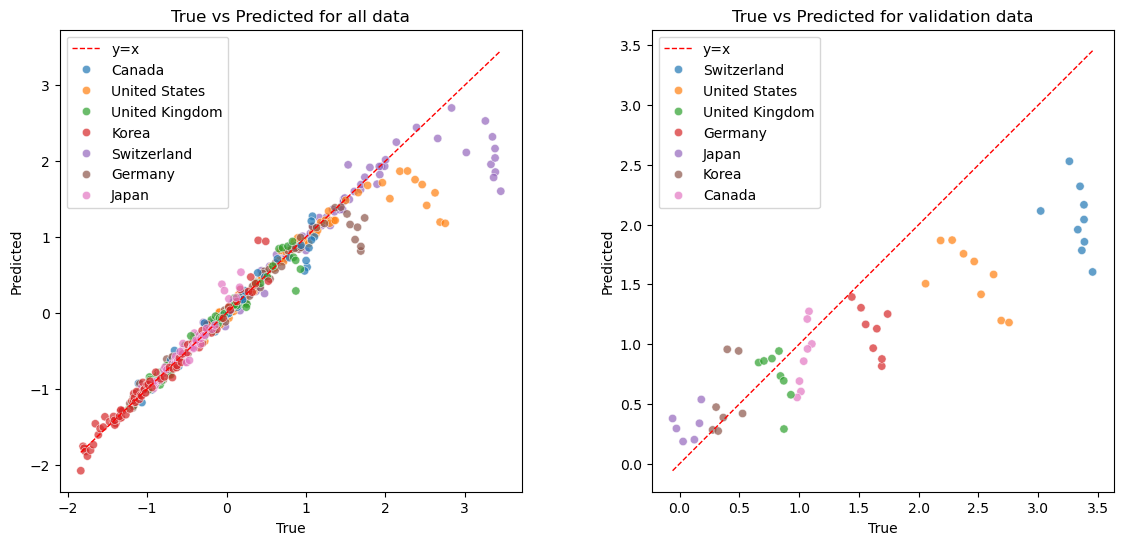

KF model :


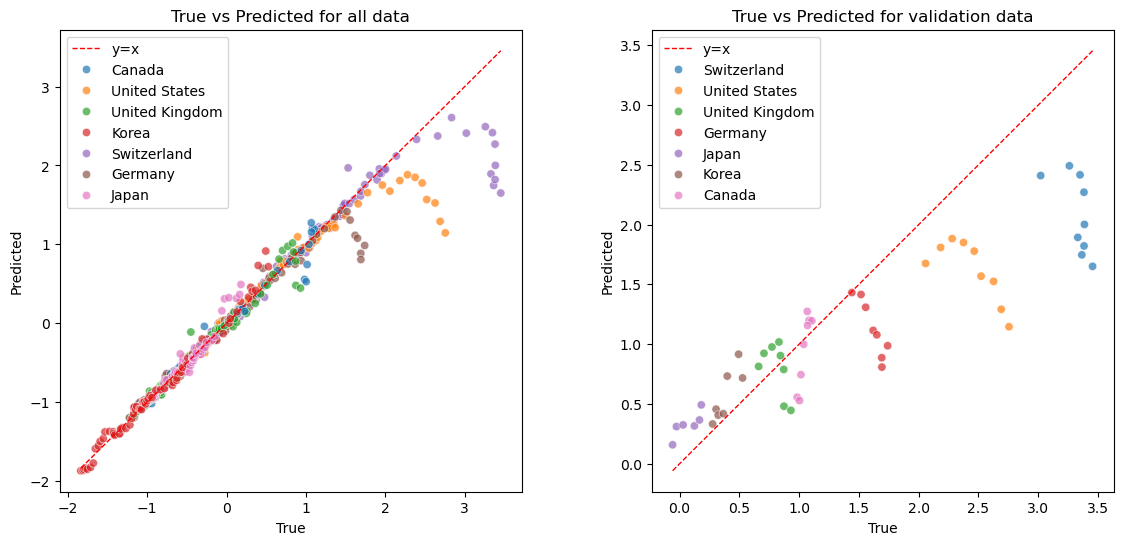

In [52]:
# Associate the result by country
y_pred_valid_country = pd.DataFrame({'date': X['date'][number_train:], 'country': country_valid, 'y_pred': y_pred_valid, 'y_true': y_valid, 'y_pred_kf': y_pred_valid_kf})
y_pred_train_country = pd.DataFrame({'date': X['date'][:number_train], 'country': country_train, 'y_pred': y_pred_train, 'y_true': y_train, 'y_pred_kf': y_pred_train_kf})

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_valid_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_pred", "y_true", "y_pred_kf"],
    var_name="Type", value_name="Value"
)

def plot_predictions_against_true(df, true_key="y_true", pred_key="y_pred"):
    plt.figure(figsize=(14, 6))

    ax = plt.subplot(1, 2, 1)
    ax.set_box_aspect(1)

    plt.plot([np.min(predictions[true_key]), np.max(predictions[true_key])], [np.min(predictions[true_key]), np.max(predictions[true_key])], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=predictions, hue='country', alpha=0.7)
    plt.title('True vs Predicted for all data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.set_box_aspect(1)

    plt.plot([np.min(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[true_key])], [np.min(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[true_key])], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=y_pred_valid_country, hue='country', alpha=0.7)
    plt.title('True vs Predicted for validation data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    plt.show()

print("Base model :")
plot_predictions_against_true(predictions, true_key="y_true", pred_key="y_pred")

print("KF model :")
plot_predictions_against_true(predictions, true_key="y_true", pred_key="y_pred_kf")

In [53]:
# Calculate Mean Squared Error
print(f"Base model : Training  ME: {mean_squared_error(y_train, y_pred_train):.4f}, Validation MSE: {mean_squared_error(y_valid, y_pred_valid):.4f}")
print(f"  KF model : Training  ME: {mean_squared_error(y_train, y_pred_train_kf):.4f}, Validation MSE: {mean_squared_error(y_valid, y_pred_valid_kf):.4f}")

# Function to plot data with confidence intervals for the selected country
def plot_by_country_with_confidence(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = filtered_data['date'].quantile(TRAIN_PROPORTION)

    plt.figure(figsize=(12, 6))
    
    # Plot predictions and true values
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )

    # Add a vertical line to indicate where validation starts
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({(TRAIN_PROPORTION)*100:.0f}%)')
    
    # Enhancing the plot
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the updated plot function
interact(plot_by_country_with_confidence, selected_country=dropdown)

Base model : Training  ME: 0.0048, Validation MSE: 0.5305
  KF model : Training  ME: 0.0038, Validation MSE: 0.5048


interactive(children=(Dropdown(description='Country:', options=('Canada', 'United States', 'United Kingdom', '…

<function __main__.plot_by_country_with_confidence(selected_country)>

In [54]:
# OLD

import shap

PLOT_SHAP = False

if PLOT_SHAP:
    explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 20))
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)
